# SDC Nanodegree P5 - Vehicle Detection Project

## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

                                                                                                ## Code Run Once

### Here we import all the dependancies of the project

In [1]:
#imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
import imghdr
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline

/home/da7th/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### The following are samples of the three types of images that will be used in the project. These images are:
* Full car-mounted camera frame at a resolution of (1280,720)
* A car image that will be used to train the classifier
* A non-car image that will be used to train the classifier

#### (Note that the training images are in PNG format when later using the classifier to predict ouputs)

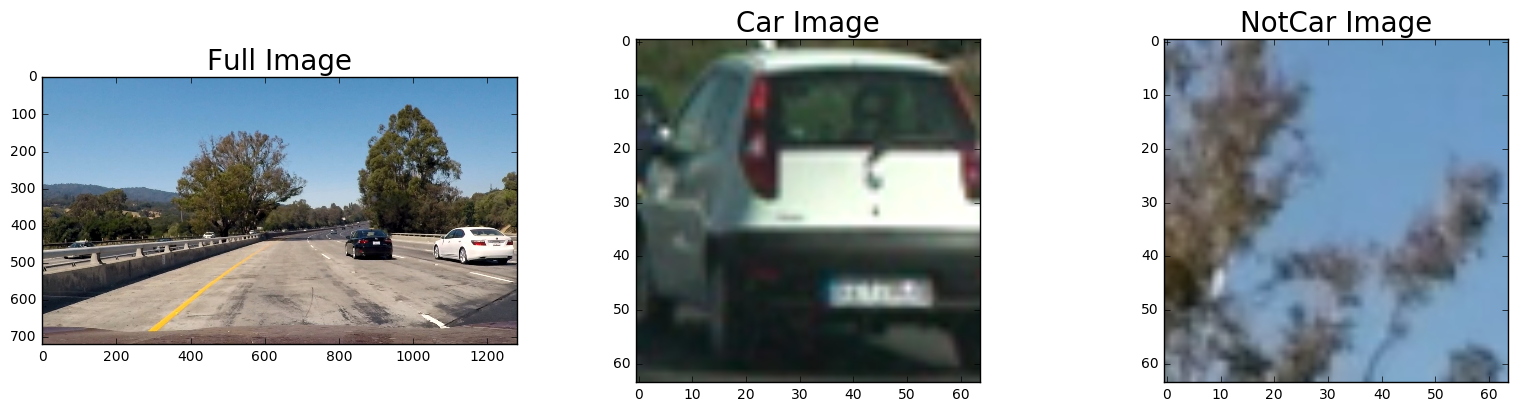

In [338]:
img_full = mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P5/test_images/test1.jpg') 
img_car = mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P5/vehicles/GTI_Right/image0301.png') 
img_notcar = mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P5/non-vehicles/Extras/extra16.png') 
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 4))
f.tight_layout()
ax1.imshow(img_full)
ax1.set_title('Full Image', fontsize=20)
ax2.imshow(img_car)
ax2.set_title('Car Image', fontsize=20)
ax3.imshow(img_notcar)
ax3.set_title('NotCar Image', fontsize=20)

### Here we load all the training and testing images from their respective folders

In [358]:
def load_image_sets():
    
    #car folders:
    imgs_png1 = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P5/vehicles/GTI_Far/*.png')
    imgs_png2 = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P5/vehicles/GTI_Left/*.png')
    imgs_png3 = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P5/vehicles/GTI_MiddleClose/*.png')
    imgs_png4 = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P5/vehicles/GTI_Right/*.png')
    imgs_png5 = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P5/vehicles/KITTI_extracted/*.png')

    #notcar folders:
    imgs_png6 = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P5/non-vehicles/Extras/*.png')
    imgs_png7 = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P5/non-vehicles/GTI/*.png')

    #concatenate all the similar images
    car_imgs = np.concatenate((imgs_png1,imgs_png2,imgs_png3,imgs_png4,imgs_png5))
    notcar_imgs = np.concatenate((imgs_png6,imgs_png7))
    
    return car_imgs, notcar_imgs

car_imgs, notcar_imgs = load_image_sets()
print("The number of non-car images is: ",len(notcar_imgs))
print("The number of car images is: ",len(car_imgs))

The number of non-car images is:  8968
The number of car images is:  9070


## Here we define the functions that will extract the fetures we need to train on.

### The 'bin_spatial' function:
* takes in an image and a specific size.
* The size is fixed for all inputs to a classifier and later the images it performs predictions on.
* This function returns a horizontal stack of the different colour channels of the image after they're resized to the given dimensions

### The 'color_hist function:
* Takes in an image and the number of bins to use.
* To have a consistent comparable feature the number of bins needs to be fixed in all operations of this function for a given classifier.
* This function splits the image to it's 3 colour channels and returns their concatenation after creating a histogram of their colour values divided into the given number of bins.


### The 'get_hog_features' function:
* Takes in a numiber of variables to use with Sklearn's hog feature extraction function.
* This is written as a function here to allow the user to choose whether or not they wish for a visualisation to be returned along with the hog-feature.
* The orient value is the number of orientations to be used in obtaining the hog feature, the greater the number the more detailed the feature and the greater the time it takes to process.
* pix_per_cell defines the number of pixels to assume for each cell that will obtain a gradient.
* cell_per_block defines the number of cells to assume for each block that will obtain a general gradient direction
* vis=False this value states whether the user receives a visualisation from the function.
* feature_vec=True this value states whether the user receives a feature vector from the function.

### The 'comb_extract_features' function:
* This function is simply a combination of the above functions.
* It takes in all the required variables with the added variable for the image's colour space to use, and if it isn't in the stated format, convert it.
* It runs the 'bin_spatial' function, the 'color_hist function and the 'get_hog_features' function and concatenates all the output features into 1 feature for the input image

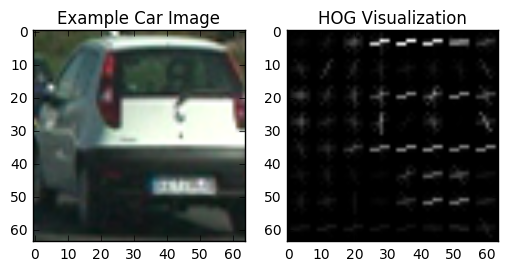

In [4]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=6):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        # features = [] # Remove this line
        # hog_image = img # Remove this line
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        features = [] # Remove this line
        return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def comb_extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=6, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


orient = 9
pix_per_cell = 8
cell_per_block = 2
gray = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
#Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## The following is the feature extraction of the all the images in both image sets

### Below is an example of a car image with it's feature plot and normalised feature plot

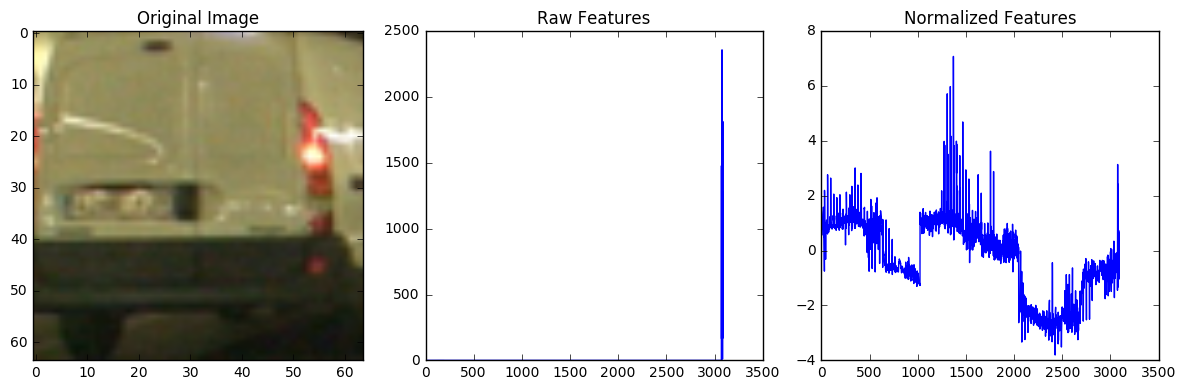

In [5]:
car_features = comb_extract_features(car_imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=6, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features = comb_extract_features(notcar_imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=6, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_imgs))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_imgs[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### The 'equalise_sets' function prevents bias during training. 
### This is done by making sure that both image sets are fed in to the classifier training process in equal sizes

In [362]:
def equalise_sets(car_features, notcar_features):    
    print("Set lengths before:", len(car_features),len(notcar_features))

    car_features = shuffle(car_features)
    notcar_features = shuffle(notcar_features)

    if len(car_features) > len(notcar_features):
        car_features = car_features[:len(notcar_features)]
    elif len(car_features) < len(notcar_features):
        notcar_features = notcar_features[:len(car_features)]

    print("Set lengths after equalise function:", len(car_features),len(notcar_features))
    
    return car_features, notcar_features


## Training the Classifier

#### The 'svc_train' function:
* Takes in the car and noncar feature sets and train a support vector machine to classify future images.
* The sets are equalised using the 'equalise_sets' function:
* Both sets are concatenated then scaled to a mean of 0 to assist in classification.
* A vector of labels is initialised for both datasets
* The datasets are then split into training and test sets at a ratio of 80 to 20% respectively
* The SVC is initialised and the training sets are used to fit the SVC
* The score function of the SVC is then used with the test set to check the accuracy of the classifier.
* A 10 element sample is printed for verification

In [363]:
def svc_train(car_features,notcar_features): 
#     print(car_features[0].shape)
    car_features, notcar_features = equalise_sets(car_features, notcar_features)
    
    X = np.vstack((car_features[:], notcar_features[:])).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features[:])), np.zeros(len(notcar_features[:]))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    svc.fit(X_train, y_train)
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    
    return svc

svc = svc_train(car_features,notcar_features)
# print(svc.dtype)

Set lengths before: 9070 8968
Set lengths after equalise function: 8968 8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3090
Test Accuracy of SVC =  0.9487
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  0.  1.  1.  1.  1.]


                                                                                      ## Code Run Multiple times

## Sliding Window Implementation

windows_n: 853


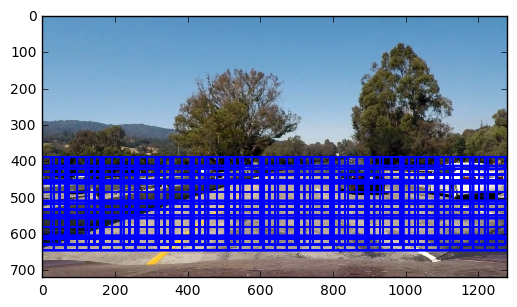

In [246]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[390, 650], 
                    xy_window=(192, 192), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    window_list = []    
    for i in range(1,5):
        x_w = int(xy_window[0]/i)
        y_w = int(xy_window[1]/i)
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(x_w*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(y_w*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(x_w*(xy_overlap[0]))
        ny_buffer = np.int(y_w*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + x_w
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + y_w

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


windows = slide_window(img_full, x_start_stop=[None, None], y_start_stop=[390, 650], 
                    xy_window=(192, 192), xy_overlap=(0.5, 0.5))
print("windows_n:",len(windows))

box_img = draw_boxes(img_full, windows)
plt.imshow(box_img)

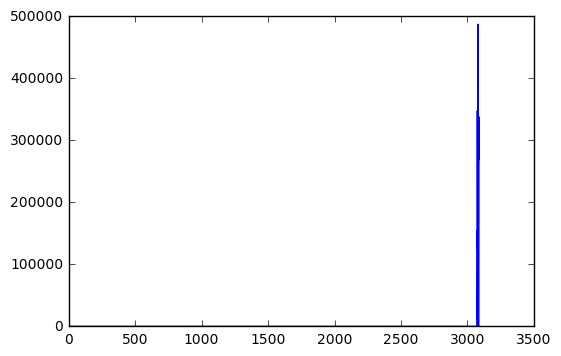

In [207]:
def bin_spatial2(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist2(img, nbins=6):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features2(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        # features = [] # Remove this line
        # hog_image = img # Remove this line
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        features = [] # Remove this line
        return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def comb_extract_features2(image, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=6, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    file_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial2(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist2(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features2(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features2(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


img_comb_extract_features2 = comb_extract_features2(img_full)
plt.plot(img_comb_extract_features2[0])

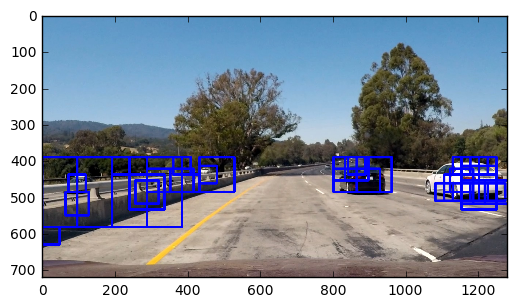

In [247]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 6    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf=svc, scaler=X_scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=6, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (32, 32))      
        #4) Extract features for that window using single_img_features()
        features = comb_extract_features2(test_img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=6, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)
        #5) Scale extracted features to be fed to classifier
#         print(features.shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
#         print(features.shape)
        #6) Predict using your classifier
#         print(clf)
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P5/test_images/test1.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

hot_windows = search_windows(image, windows, clf=svc, scaler=X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)      

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

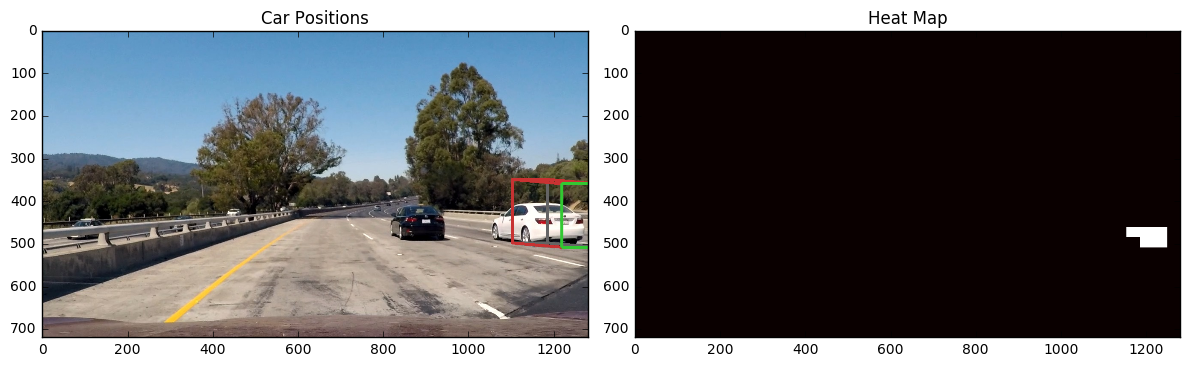

In [354]:


def add_heat(heatmap, bbox_list=hot_windows):
    # Iterate through list of bboxes
    
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        
        #cube Attempt
        x1 = np.min(nonzerox)
        x2 = np.max(nonzerox)
        y1 = np.min(nonzeroy)
        y2 = np.max(nonzeroy)
        
        #original detection
#         cv2.rectangle(img, (x1,y1), (x2,y2), (100,100,200), 6)
        
        
        centroidx = int((x1+x2)/2) 
        centroidy = int((x1+x2)/2) 
        
        width_half = int((50+(y2-360))/2)
        x1 = centroidx - width_half
        x2 = centroidx + width_half
        
        gap = int((78)/((240)/(414-x1))) + 106
        tilt = 10
        
        
#         cv2.rectangle(img, (x1,y1), (x2,y2), (100,200,200), 6)
        
        cv2.rectangle(img, (x1,350), (x2+gap,y2-tilt), (100,100,100), 6)
        cv2.line(img, (x1-gap,y2), (x1,y2-tilt), (200,50,50), 6)
        cv2.line(img, (x1,y2-tilt), (x1,350), (200,50,50), 6)
        cv2.line(img, (x1,350), (x2+gap,350), (200,50,50), 6)
        cv2.line(img, (x1-gap,360), (x1,350), (200,50,50), 6)
        cv2.line(img, (x2+gap,350), (x2,360), (200,50,50), 6)
        cv2.line(img, (x2+gap,y2-tilt), (x2,y2), (100,100,100), 6)
        cv2.rectangle(img, (x1-gap,360), (x2,y2), (50,200,50), 6)
    # Return the image
    return img

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


# fig = plt.figure(figsize=(12,4))
#     plt.subplot(131)
#     plt.imshow(mpimg.imread(car_imgs[car_ind]))
#     plt.title('Original Image')
#     plt.subplot(132)
#     plt.plot(X[car_ind])
#     plt.title('Raw Features')
#     plt.subplot(133)
#     plt.plot(scaled_X[car_ind])
#     plt.title('Normalized Features')
#     fig.tight_layout()

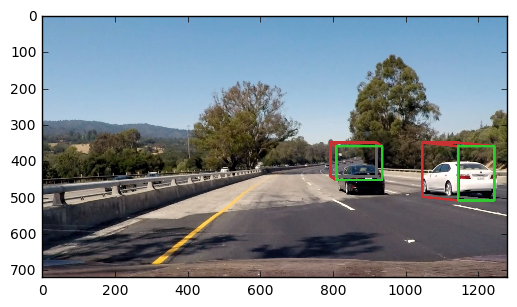

In [359]:
#PIPELINES
# svc_created = 0
# svc = 0

hot_wind_collection = []

def pipeline(img):
    
    global hot_wind_collection
    
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 6    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [350, 650] # Min and max in y to search in slide_window()
    
    
    
    draw_image = np.copy(img)
    image = img.astype(np.float32)/255

    hot_windows = search_windows(image, windows, clf=svc, scaler=X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)      
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    
    if hot_windows != []:
        hot_wind_collection.append(hot_windows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    if len(hot_wind_collection) > 5:
        # Add heat to each box in box list
        heat = add_heat(heat,hot_wind_collection[-1])
        heat = apply_threshold(heat,4)
        heat = add_heat(heat,hot_wind_collection[-2])
        heat = apply_threshold(heat,4)
        heat = add_heat(heat,hot_wind_collection[-3])
        heat = apply_threshold(heat,4)
        heat = add_heat(heat,hot_wind_collection[-4])
        heat = apply_threshold(heat,4)
        heat = add_heat(heat,hot_wind_collection[-5])
        heat = apply_threshold(heat,4)
        heat = add_heat(heat,hot_wind_collection[-6])
        heat = apply_threshold(heat,4)
        
        # Apply threshold to help remove false positives
#         heat = apply_threshold(heat,6)
    else:
        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
#     plt.imshow(window_img)

    return draw_img


image = mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P5/test_images/test4.jpg')
# print(image.dtype)
plt.imshow(pipeline(image))

In [360]:
heat_maps = []
white_output = '/home/da7th/Desktop/Udacity/sdc/CarND-P5/white2.mp4'
# clip1 = VideoFileClip("/home/da7th/Desktop/Udacity/sdc/CarND-P5/project_video.mp4").subclip(17,20)
clip1 = VideoFileClip("/home/da7th/Desktop/Udacity/sdc/CarND-P5/project_video.mp4")
# reset_lines()
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /home/da7th/Desktop/Udacity/sdc/CarND-P5/white2.mp4
[MoviePy] Writing video /home/da7th/Desktop/Udacity/sdc/CarND-P5/white2.mp4


100%|█████████▉| 1260/1261 [30:47<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/da7th/Desktop/Udacity/sdc/CarND-P5/white2.mp4 

CPU times: user 30min 33s, sys: 9.96 s, total: 30min 43s
Wall time: 30min 49s
